In [1]:
import numpy as np
import torch as th
import matplotlib.pylab as plt
from optical_nn import *
import complex_torch_var as ct
from mnist import *
import os
from time import time
from functools import partial
from glob import glob
from default_params import *

Using CPU


In [2]:
def load_complex(f=F_COMPLEX_TRAIN):
    net = mnist_complex()
    print(net)
    net.load_state_dict(th.load(f, map_location=DEVICE))
    return net.to(DEVICE)

In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)



In [4]:
def load_cnn(f=F_CNN_TRAIN):
    print(f)
    net = Net()
    print(net)
    net.load_state_dict(th.load(f, map_location=DEVICE))
    return net.to(DEVICE)

Sequential(
  (0): ComplexConvolution()
  (1): MaxPooling()
  (2): ComplexLinear()
  (3): ModNonlinearity(
    (f): SineModulator()
  )
  (4): ComplexLinear()
  (5): ModNonlinearity(
    (f): SineModulator()
  )
  (6): ComplexLinear()
  (7): ComplexNorm()
  (8): LogSoftmax()
)
(0.9728000164031982, array([[ 967,    0,    3,    1,    0,    2,    2,    1,    1,    3],
       [   0, 1126,    1,    3,    0,    1,    1,    0,    3,    0],
       [   3,    2, 1008,    3,    1,    2,    2,    6,    4,    1],
       [   0,    1,    2,  981,    0,   10,    0,    5,    4,    7],
       [   0,    0,    8,    1,  946,    0,    3,    5,    0,   19],
       [   5,    3,    0,   16,    0,  858,    5,    1,    3,    1],
       [   9,    2,    3,    1,    4,   10,  928,    0,    1,    0],
       [   1,   10,    7,    2,    2,    0,    0,  992,    5,    9],
       [   4,    1,    1,    3,    2,    3,    3,    2,  950,    5],
       [   2,    3,    0,   10,   11,    3,    0,    5,    3,  972]],
      dtyp

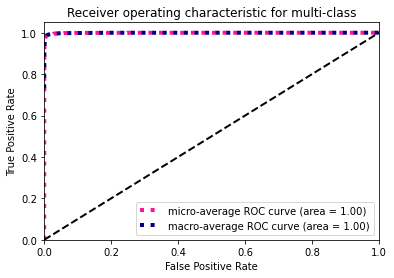

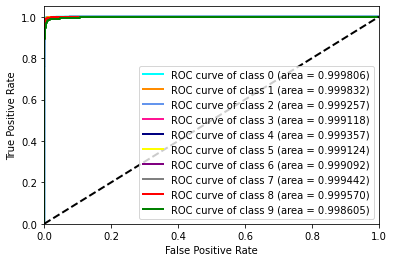

In [6]:
import numpy as np
import torch
from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import roc_curve, auc
import math

model = load_complex()
for data, target in mnist_loader(train=False, batch_size=10000, shuffle=False):
    continue
data = data.view(-1, 28**2)
data, target = data.to(DEVICE), target.to(DEVICE)
Y_pred = model(data)
out = Y_pred.data.max(1, keepdim=True)[1]
print(get_acc(model))
Y_pred = torch.exp(Y_pred)
Y_pred.detach()
Y_real = torch.zeros((10000, 10), requires_grad = False)
Y_pred = Y_pred.detach().numpy()
for i in range(10000):
    Y_real[i][target[i]] = 1
# Plot linewidth.
Y_real = Y_real.numpy()
lw = 2

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(10):
    temp = []
    fpr[i], tpr[i], _ = roc_curve(Y_real[:, i], Y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(Y_real.ravel(), Y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(10)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(10):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= 10

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr



roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot micro/macro ROC curves
plt.figure(1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class')
plt.legend(loc="lower right")
plt.show()

# Plot class ROC curves
plt.figure(2)
colors = cycle(['aqua', 'darkorange', 'cornflowerblue','deeppink','navy','yellow','purple','gray','red','green','brown','blue'])
for i, color in zip(range(10), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.6f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('')
plt.legend(loc="lower right")
plt.savefig('QOCNN.png')
plt.show()